In [2]:
%load_ext autoreload
%autoreload 2

from PyDeep import *
from sklearn.datasets import make_regression, make_classification, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm
import pandas as pd

In [3]:
SEED = 12

## Multiple regression

In [ ]:
N, D, K, b = 1000, 1, 2, 10

X, Y = make_regression(n_samples=N, n_features=D, n_targets=K, bias=b, noise=10, random_state=SEED)
if K == 1:  Y = Y[..., None]

In [13]:
reg_model = Sequential(Linear(D, D*3),
                Linear(D*3, K))

criterion = MSE()

optim = SGD(reg_model, 1e-3)

routine = Trainer(X=X, Y=Y, model=reg_model, criterion=criterion, optim=optim, batch_size=32, epochs=1000, train_size=0.5, pace_eval_test=2, seed=SEED)

init_pred = reg_model(np.arange(np.min(X), np.max(X) + 1)[:, None])

TRAINING:   0%|          | 0/1000 [00:00<?, ?it/s]

TRAINING: 100%|██████████| 1000/1000 [00:04<00:00, 244.08it/s]


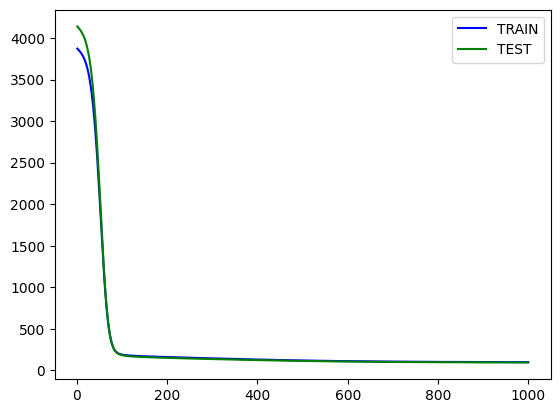

In [14]:
utils.plot(
    (*(rez := routine.training())[:2], "TRAIN"),
    (*rez[2:], "TEST")
)

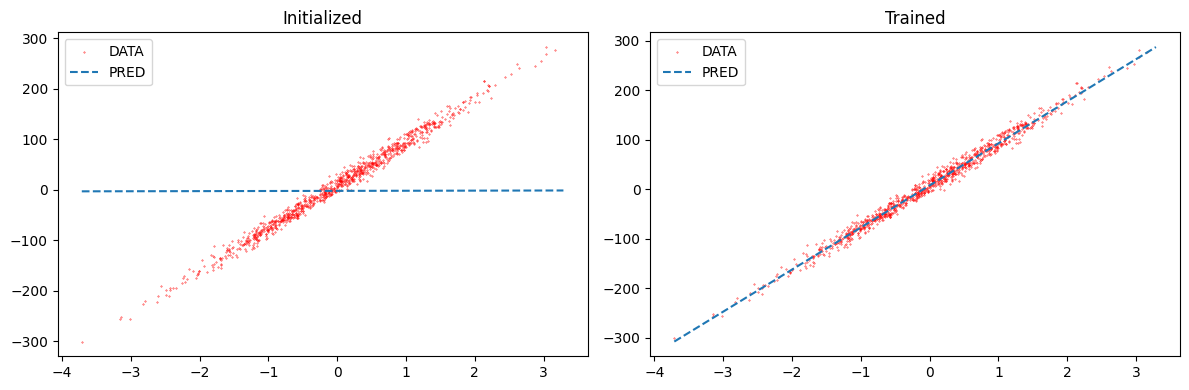

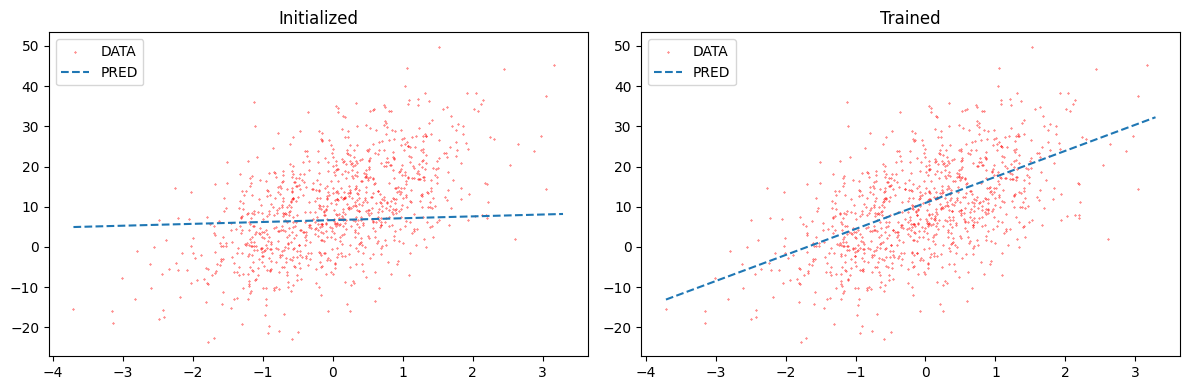

In [15]:
x_range = np.arange(np.min(X), np.max(X) + 1)[:, None]

for i in range(K):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].scatter(X[:, 0], Y[:, i], s=0.1, label="DATA", c="red")
    axes[0].plot(x_range[:, 0], init_pred[:, i], linestyle="--", label="PRED")
    axes[0].set_title("Initialized")
    axes[0].legend()

    axes[1].scatter(X[:, 0], Y[:, i], s=0.1, label="DATA", c="red")
    axes[1].plot(x_range[:, 0], reg_model(x_range, track=False)[:, i], linestyle="--", label="PRED")
    axes[1].set_title("Trained")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    plt.close()

## Binary classification

In [4]:
N, D, K = 1000, 2, 2

X, Y = make_moons(n_samples=N, random_state=SEED)
Y = Y[..., None]

In [5]:
bclf_model = Sequential(
                Linear(D, D*3),
                Tanh(D*3),       
                Linear(D*3, K),
                Tanh(K),
                Linear(K, K-1),
                Sigmoid(K-1))

criterion = BCE()

optim = SGD(bclf_model, 1e-2)

routine = Trainer(X=X, Y=Y, model=bclf_model, criterion=criterion, optim=optim, batch_size=32, epochs=2000, train_size=0.99, pace_eval_test=2, seed=SEED)

In [6]:
init = utils.decision_boundary(X, lambda x: np.where(bclf_model(x) >= 0.5, 1, 0))

TRAINING: 100%|██████████| 2000/2000 [00:46<00:00, 43.29it/s]


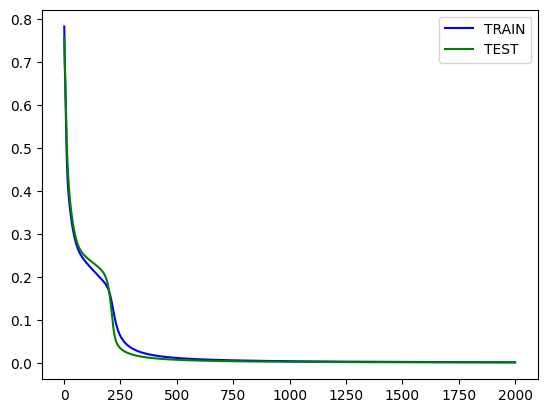

In [7]:
utils.plot(
    (*(rez := routine.training())[:2], "TRAIN"),
    (*rez[2:], "TEST")
)

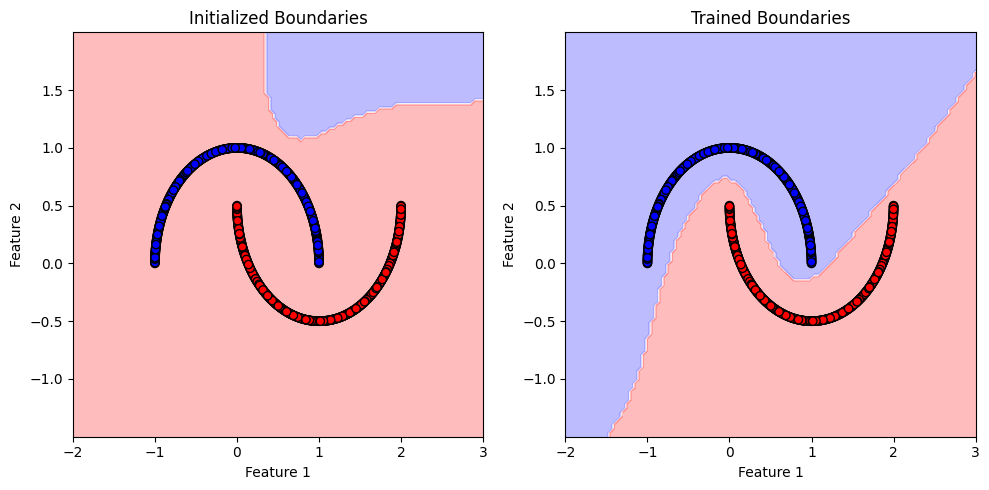

In [8]:
utils.boundary_comparison(X, Y, lambda x: np.where(bclf_model(x) >= 0.5, 1, 0), init)

## Multi classification

### Softmax + Cross-Entropy

In [3]:
N, D, K = 1000, 2, 4

X, Y = make_classification(n_samples=N, n_features=D, n_informative=D, n_redundant=0, n_classes=K, flip_y=0, class_sep=3, n_clusters_per_class=1, random_state=SEED)
Y_oh = np.eye(K)[Y]
Y = Y[..., None]

In [4]:
mclf_model = Sequential(
    Linear(D, D),
    Tanh(D),
    Linear(D, K),
    Softmax(K)
)

criterion = CE()

optim = SGD(mclf_model, 1e-2)

routine = Trainer(X=X, Y=Y_oh, model=mclf_model, criterion=criterion, optim=optim, batch_size=32, epochs=2000, train_size=0.99, pace_eval_test=2, seed=SEED)

In [5]:
init = utils.decision_boundary(X, lambda x: np.argmax(mclf_model(x, track=False), axis=1))

TRAINING: 100%|██████████| 2000/2000 [00:22<00:00, 89.10it/s]


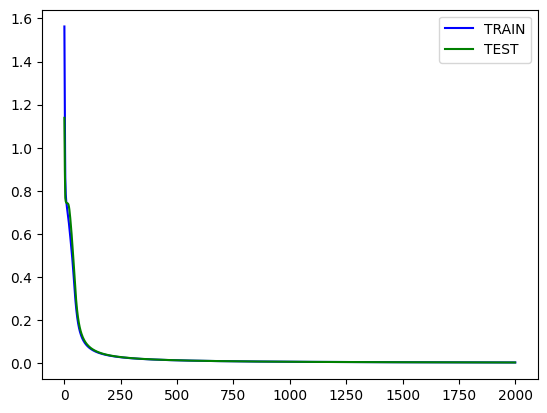

In [6]:
utils.plot(
    (*(rez := routine.training())[:2], "TRAIN"),
    (*rez[2:], "TEST")
)

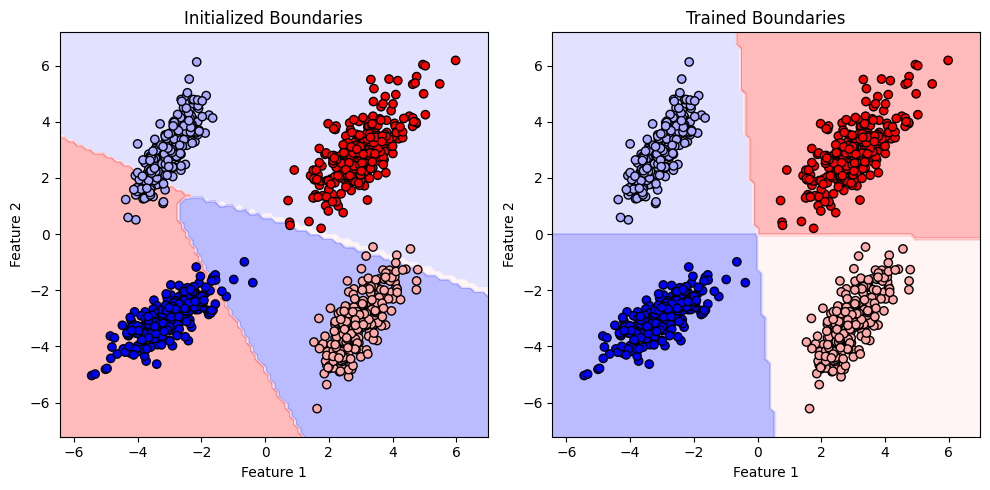

In [7]:
utils.boundary_comparison(X, Y, lambda x: np.argmax(mclf_model(x, track=False), axis=1), init)

### Log-Softmax + Log-Cross-Entropy

In [82]:
N, D, K = 1000, 2, 4

X, Y = make_classification(n_samples=N, n_features=D, n_informative=D, n_redundant=0, n_classes=K, flip_y=0, class_sep=3, n_clusters_per_class=1, random_state=SEED)
Y_oh = np.eye(K)[Y]
Y = Y[..., None]

In [83]:
log_mclf_model = Sequential(
    Linear(D, D),
    Sigmoid(D),
    Linear(D, K),
    Identity(K),
    LogSoftmax(K, tau=10)
)

criterion = LogCE()

optim = SGD(log_mclf_model, 1e-2)

routine = Trainer(X=X, Y=Y_oh, model=log_mclf_model, criterion=criterion, optim=optim, batch_size=32, epochs=1000, train_size=0.99, pace_eval_test=2, seed=SEED)

In [84]:
init = utils.decision_boundary(X, lambda x: np.argmax(log_mclf_model(x, track=False), axis=1))

TRAINING:   0%|          | 0/1000 [00:00<?, ?it/s]

TRAINING: 100%|██████████| 1000/1000 [00:13<00:00, 71.51it/s]


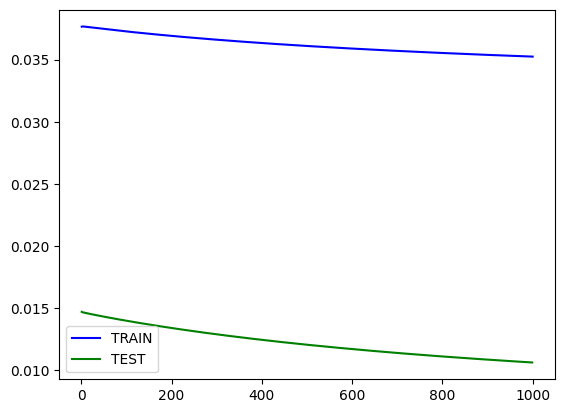

In [91]:
utils.plot(
    (*(rez := routine.training())[:2], "TRAIN"),
    (*rez[2:], "TEST")
)

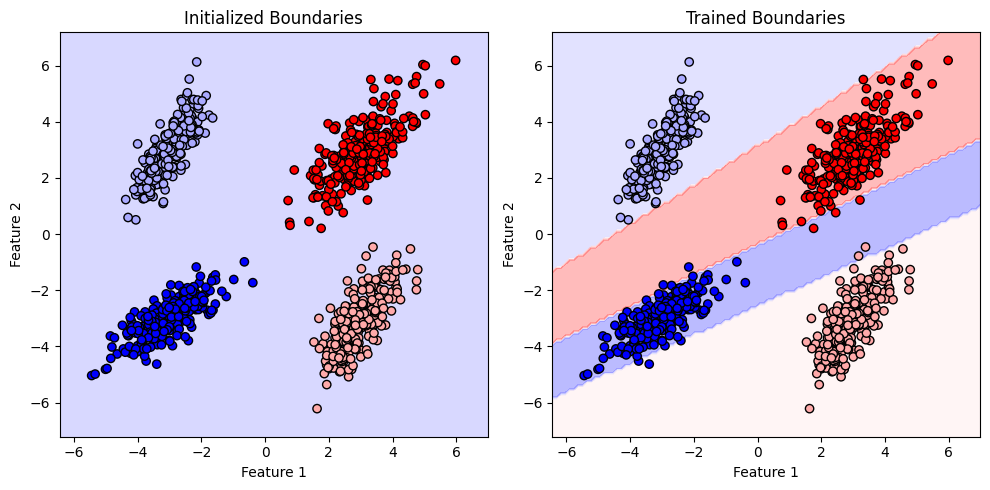

In [92]:
utils.boundary_comparison(X, Y, lambda x: np.argmax(log_mclf_model(x, track=False), axis=1), init)

## Concat

In [278]:
N, D, K = 1000, 2, 4

X, Y = make_classification(n_samples=N, n_features=D, n_informative=D, n_redundant=0, n_classes=K, flip_y=0, class_sep=3, n_clusters_per_class=1, random_state=SEED)
Y_oh = np.eye(K)[Y]
Y = Y[..., None]

In [286]:
bi_model = Sequential(
    Concat(
        Linear(D//2, (D*10)//2),
        Linear(D//2, (D*10)//2)
    ),
    Sigmoid(D*10),
    Concat(
        Linear((D*10)//2, D*20),
        Linear((D*10)//2, D*20)
    ),
    Sigmoid(D*40),
    Linear(D*40, K),
    Softmax(K, tau=3)
)

criterion = CE()

optim = SGD(bi_model, 1e-1)

routine = Trainer(X=X, Y=Y_oh, model=bi_model, criterion=criterion, optim=optim, batch_size=1, epochs=100, train_size=0.99, pace_eval_test=2, seed=SEED)

In [287]:
init = utils.decision_boundary(X, lambda x: np.argmax(bi_model(x, track=False), axis=1))

TRAINING:   0%|          | 0/100 [00:00<?, ?it/s]

TRAINING: 100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


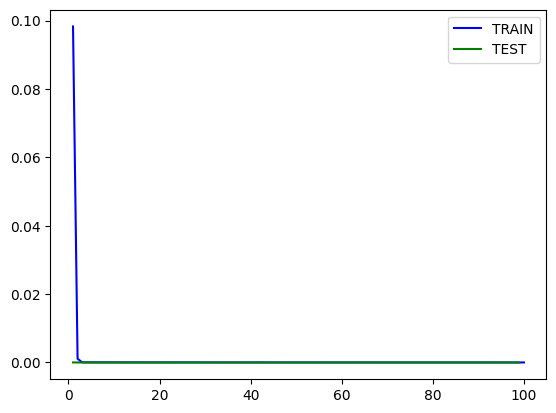

In [288]:
utils.plot(
    (*(rez := routine.training())[:2], "TRAIN"),
    (*rez[2:], "TEST")
)

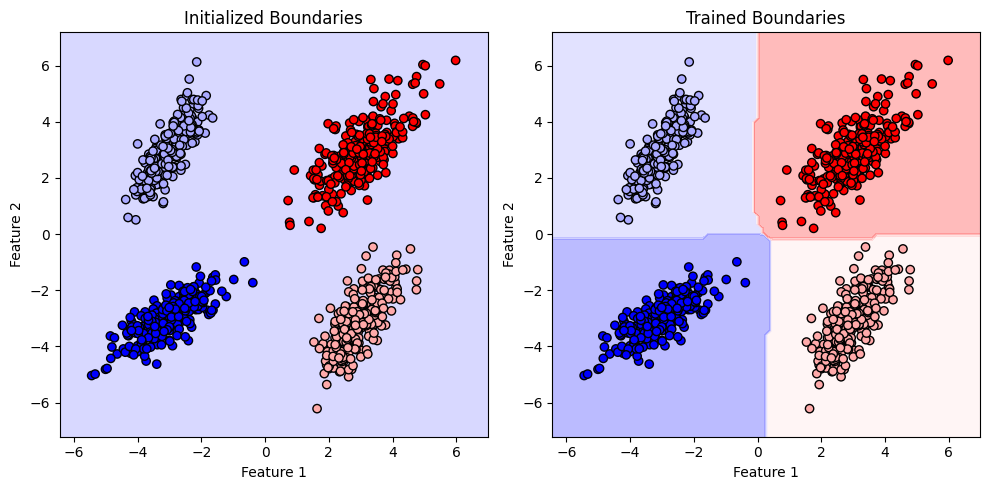

In [289]:
utils.boundary_comparison(X, Y, lambda x: np.argmax(bi_model(x, track=False), axis=1), init)

## Classification + Regression

In [63]:
X, Y = make_regression(n_samples=1000, n_features=2, n_targets=1, bias=10, noise=10, random_state=SEED)
Yclass = (2*X[:, 0] - 0.25*X[:, 1] > 2).astype(int)
Y_oh = np.eye(2)[Yclass]
Y = Y[:, None]

In [64]:
double_task_model = Sequential(
    Concat(
        Linear(2, 10),
        Linear(2, 10),
    ),
    Concat(
        Tanh(10),
        Sigmoid(10)
    ),
    Linear(20, 3),
    Concat(
        Identity(1),
        Sigmoid(2)
    ),
    Concat(
        Identity(1),
        Softmax(2, tau=2)
    )
)

criterion = SummedLoss(
    (1, MSE(1, 1)),
    (3, CE(2, 1))
)

optim = SGD(double_task_model, 1e-1)

routine = Trainer(X=np.concatenate([X, X], axis=1), Y=np.concatenate([Y, Y_oh], axis=1), model=double_task_model, criterion=criterion, optim=optim, batch_size=64, epochs=500, train_size=0.99, pace_eval_test=2, seed=SEED)

In [65]:
init = utils.decision_boundary(X, lambda x: np.argmax(double_task_model(np.concatenate([x, x], axis=1), track=False)[:, 1:], axis=1))
init_reg = double_task_model(np.concatenate([X, X], axis=1), track=False)[:, 0]

TRAINING:   0%|          | 0/500 [00:00<?, ?it/s]

TRAINING: 100%|██████████| 500/500 [00:09<00:00, 54.05it/s]


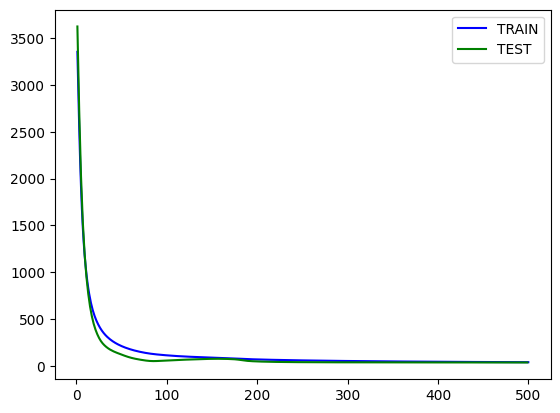

In [66]:
utils.plot(
    (*(rez := routine.training())[:2], "TRAIN"),
    (*rez[2:], "TEST")
)

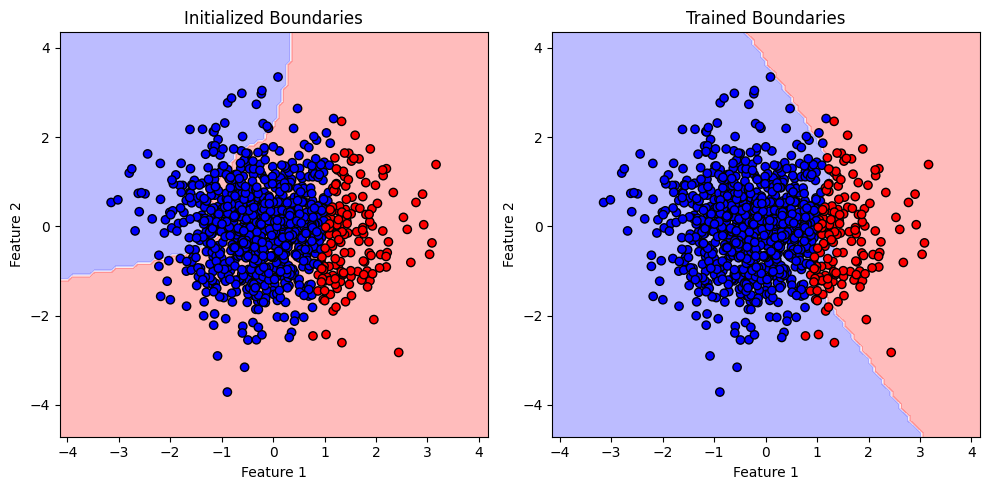

In [67]:
utils.boundary_comparison(X, Yclass, lambda x: np.argmax(double_task_model(np.concatenate([x, x], axis=1), track=False)[:, 1:], axis=1), init)

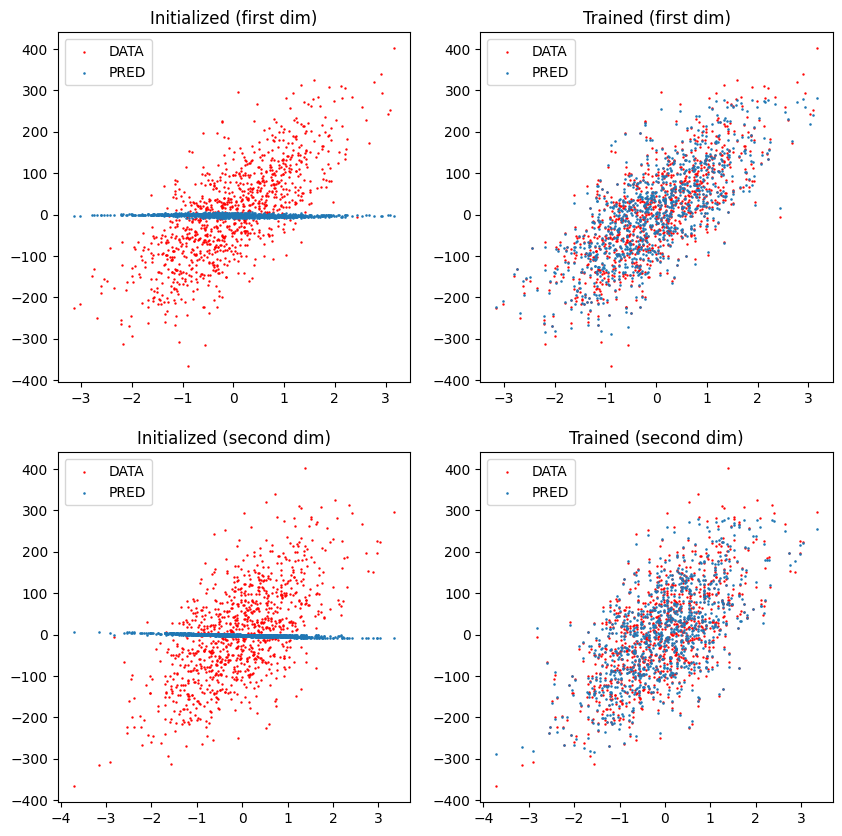

In [69]:
fig = plt.figure(figsize=(10, 10))
ax = fig.subplot_mosaic("13\n24")

ax["1"].scatter(X[:,0], Y[:,0], s=0.5, c="red", label="DATA")
ax["1"].scatter(X[:, 0], init_reg, label="PRED", s=0.7)
ax["1"].set_title("Initialized (first dim)")
ax["1"].legend()

ax["2"].scatter(X[:,1], Y[:,0], s=0.5, c="red", label="DATA")
ax["2"].scatter(X[:, 1], init_reg, label="PRED", s=0.7)
ax["2"].set_title("Initialized (second dim)")
ax["2"].legend()

ax["3"].scatter(X[:,0], Y[:,0], s=0.5, c="red", label="DATA")
ax["3"].scatter(X[:, 0], double_task_model(np.concatenate([X, X], axis=1), track=False)[:, 0], label="PRED", s=0.7)
ax["3"].set_title("Trained (first dim)")
ax["3"].legend()

ax["4"].scatter(X[:,1], Y[:,0], s=0.5, c="red", label="DATA")
ax["4"].scatter(X[:, 1], double_task_model(np.concatenate([X, X], axis=1), track=False)[:, 0], label="PRED", s=0.7)
ax["4"].set_title("Trained (second dim)")
ax["4"].legend()

plt.show()
plt.close()